# Building Fault Classification using Scikit-Learn


## **1. Install required dependencies**


In [154]:
import pandas as pd
import random
import numpy as np
import openpyxl
from matplotlib import pyplot as plt
import scikitplot as skplt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus
from sklearn import tree

ImportError: cannot import name 'plot_roc_curve' from 'sklearn.metrics' (/home/julie-vienne/mambaforge/envs/fault_detection/lib/python3.11/site-packages/sklearn/metrics/__init__.py)

## **2. Load and Process the Data**

In [141]:
SEED = 123456
np.random.seed(SEED)
random.seed(SEED)

In [142]:
def load_and_process(filename):
    cwd = os.getcwd()
    df = pd.read_csv(f"{cwd}/Data/{filename}.csv", delimiter=',')
    # Remove datetime and labels 
    X_raw = df[df.columns[1:-1]]
    # Labels
    y_raw = df.iloc[:,-1]
    return df, X_raw, y_raw

def split_and_scale(X_raw, y_raw):
    X_train, X_test, y_train, y_test = train_test_split(
    X_raw,
    y_raw,
    test_size=0.25,
    random_state = SEED
    )
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test
    

## **3. Train a Logistic Regression or Decision Tree Model from Labels**

In [143]:
def train_classifier(algorithm, X_train, y_train):
    if algorithm == 'logistic_regression':
        clf = LogisticRegression()
    elif algorithm == 'decision_tree':
        clf = DecisionTreeClassifier(max_depth=6)
    clf.fit(X_train, y_train)
    return clf

def test_accuracy(clf, X_test, y_test, X_train, y_train):
    acc_og_test = clf.score(X_test, y_test)
    print(f"Test accuracy of logistic regression on test dataset: {acc_og_test}")
    acc_og_train = clf.score(X_train, y_train)
    print(f"Test accuracy of logistic regression on train dataset: {acc_og_train}")

def plot_test_results(clf, X_test, y_test):
    y_pred_test = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred_test)
    cm_display = ConfusionMatrixDisplay(cm).plot()
    y_pred_prob = clf.predict_proba(X_test)
    y_pred_prob = np.array([t[0] for t in y_pred_prob])
    fig, ax = plt.subplots()
    ax.plot(y_pred_prob)
    ax.set_title('prediction probability of first 2000 entries of test dataset')
    fig.set_size_inches(18.5, 6)
    plt.xlim([0, 2000])

def coefficients_intercept(df, clf):

    print(clf.coef_, clf.intercept_)
    print(df.columns[1:-1])
    return clf.coef_, clf.intercept_

def plot_decision_tree(clf, df, filename):
    dot_data = StringIO()
    export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = df.columns[1:-1],class_names=['0','1'])
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    graph.write_png(f'{filename}_decision_tree.png')
    Image(graph.create_png())

def plot_rate_precision(clf, X_test, y_test):
    y_score = clf.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=clf.classes_[1])
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
    prec, recall, _ = precision_recall_curve(y_test, y_score, pos_label=clf.classes_[1])
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
    roc_display.plot(ax=ax1)
    pr_display.plot(ax=ax2)
    plt.show()

## **3. MZVAV-1 Results**

#### Load and if needed, clean the data

In [144]:
filename = 'MZVAV-1'
df, X_raw, y_raw = load_and_process(filename)
df

,Datetime,AHU: Supply Air Temperature,AHU: Supply Air Temperature Set Point,AHU: Outdoor Air Temperature,AHU: Mixed Air Temperature,AHU: Return Air Temperature,AHU: Supply Air Fan Status,AHU: Return Air Fan Status,AHU: Supply Air Fan Speed Control Signal,AHU: Return Air Fan Speed Control Signal,AHU: Outdoor Air Damper Control Signal,AHU: Return Air Damper Control Signal,AHU: Cooling Coil Valve Control Signal,AHU: Heating Coil Valve Control Signal,AHU: Supply Air Duct Static Pressure Set Point,AHU: Supply Air Duct Static Pressure,Occupancy Mode Indicator,Fault Detection Ground Truth
0,1/30/2017 0:00,68.00,55.04,32.00,68.00,75.20,0,0,0.0,0.0,0.0,0.0,0.00,0,0.04,0.00,0,0
1,1/30/2017 0:01,67.99,55.04,32.00,66.71,75.20,0,0,0.0,0.0,0.0,0.0,0.00,0,0.04,0.00,0,0
2,1/30/2017 0:02,67.99,55.04,-5.93,66.71,74.45,0,0,0.0,0.0,0.0,0.0,0.00,0,0.04,0.00,0,0
3,1/30/2017 0:03,67.99,55.04,-5.88,66.71,74.04,0,0,0.0,0.0,0.0,0.0,0.00,0,0.04,0.00,0,0
4,1/30/2017 0:04,67.99,55.04,-5.83,66.71,73.56,0,0,0.0,0.0,0.0,0.0,0.00,0,0.04,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272155,12/17/2017 23:55,55.04,55.04,17.89,62.52,62.53,1,1,1.0,1.0,0.0,0.0,0.01,0,0.04,0.11,0,1
272156,12/17/2017 23:56,55.04,55.04,17.87,62.52,62.53,1,1,1.0,1.0,0.0,0.0,0.01,0,0.04,0.11,0,1
272157,12/17/2017 23:57,55.04,55.04,17.85,62.52,62.53,1,1,1.0,1.0,0.0,0.0,0.01,0,0.04,0.11,0,1
272158,12/17/2017 23:58,55.04,55.04,17.83,62.52,62.52,1,1,1.0,1.0,0.0,0.0,0.01,0,0.04,0.11,0,1


In [145]:
X_train, X_test, y_train, y_test = split_and_scale(X_raw, y_raw)

#### Logistic Regression

Test accuracy of logistic regression on test dataset: 0.8553057025279247
Test accuracy of logistic regression on train dataset: 0.8577552420145013
[[ 4.88993108e-02  3.79609133e-14 -2.70367548e-02  1.63015034e-02
   1.52639475e-02 -8.05178619e-02 -8.05178619e-02  1.09937598e-01
   1.09937598e-01  3.67786279e-02  2.29587053e-02 -4.14950815e-02
   6.43495577e-04 -1.23570681e-17 -9.39648369e-02  1.20146961e-02]] [1.79836437]
Index(['AHU: Supply Air Temperature', 'AHU: Supply Air Temperature Set Point',
       'AHU: Outdoor Air Temperature', 'AHU: Mixed Air Temperature',
       'AHU: Return Air Temperature', 'AHU: Supply Air Fan Status',
       'AHU: Return Air Fan Status',
       'AHU: Supply Air Fan Speed Control Signal',
       'AHU: Return Air Fan Speed Control Signal',
       'AHU: Outdoor Air Damper Control Signal  ',
       'AHU: Return Air Damper Control Signal',
       'AHU: Cooling Coil Valve Control Signal',
       'AHU: Heating Coil Valve Control Signal',
       'AHU: Supply Ai

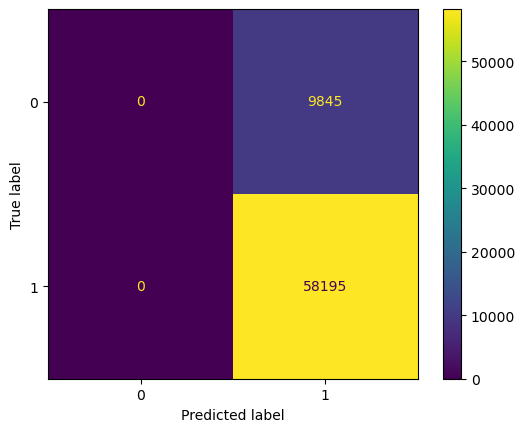

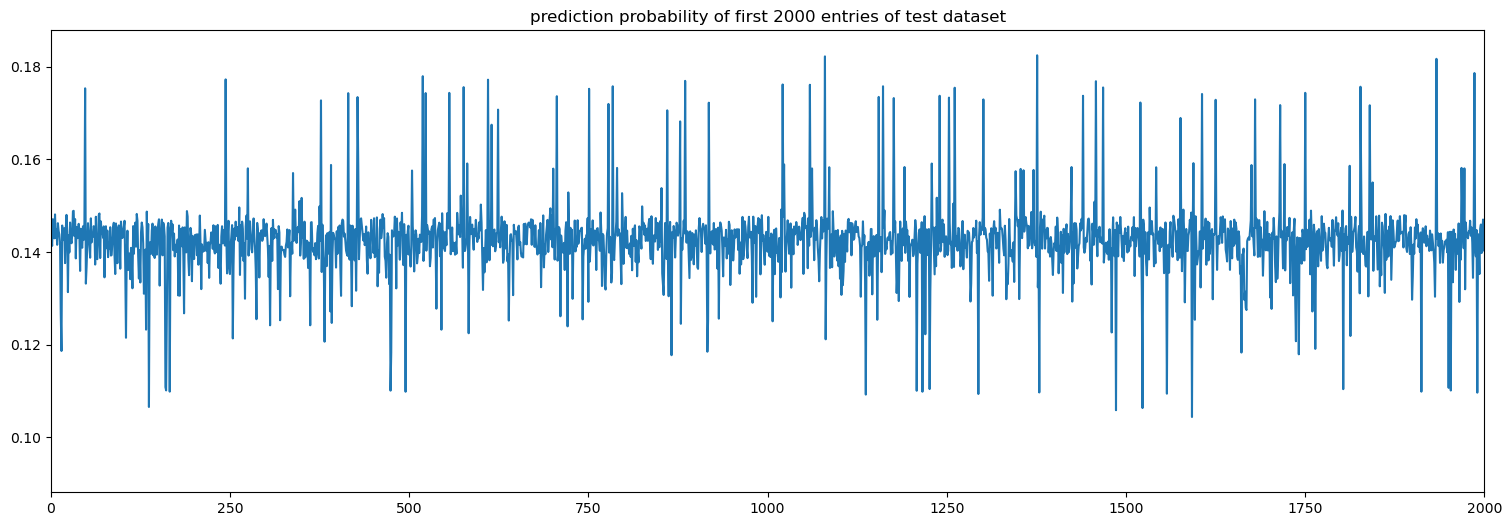

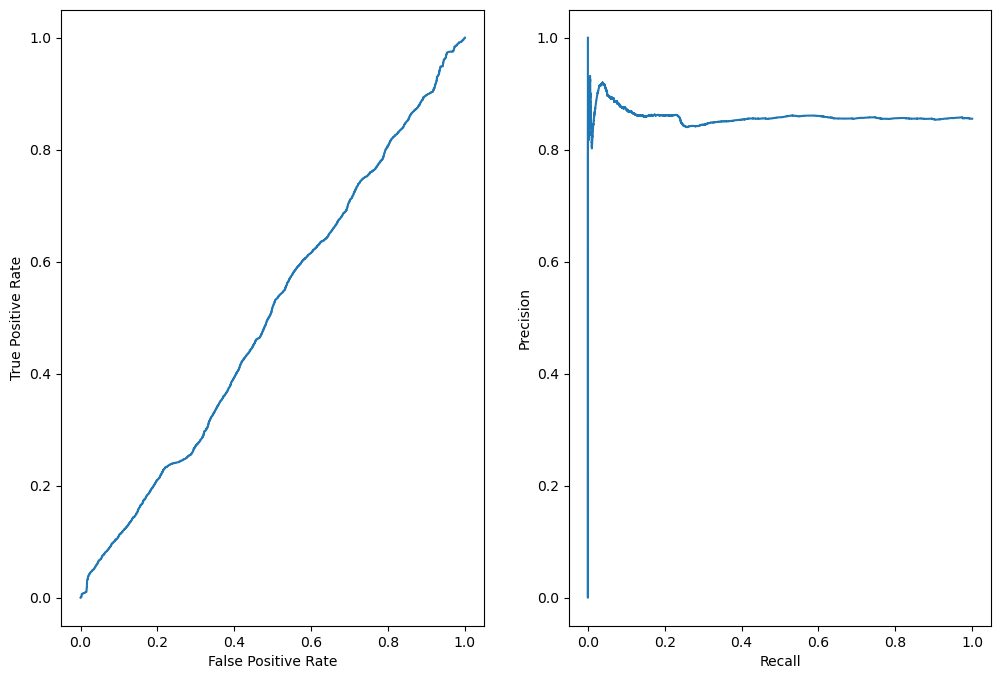

In [146]:
clf = train_classifier('logistic_regression', X_train, y_train)
test_accuracy(clf, X_test, y_test, X_train, y_train)
plot_test_results(clf, X_test, y_test)
coeff, intercept = coefficients_intercept(df, clf)
plot_rate_precision(clf, X_test, y_test)

#### Decision Tree

Test accuracy of logistic regression on test dataset: 0.8590388007054673
Test accuracy of logistic regression on train dataset: 0.8611943954536547


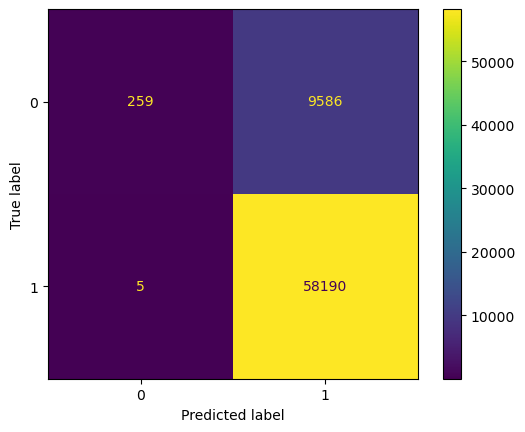

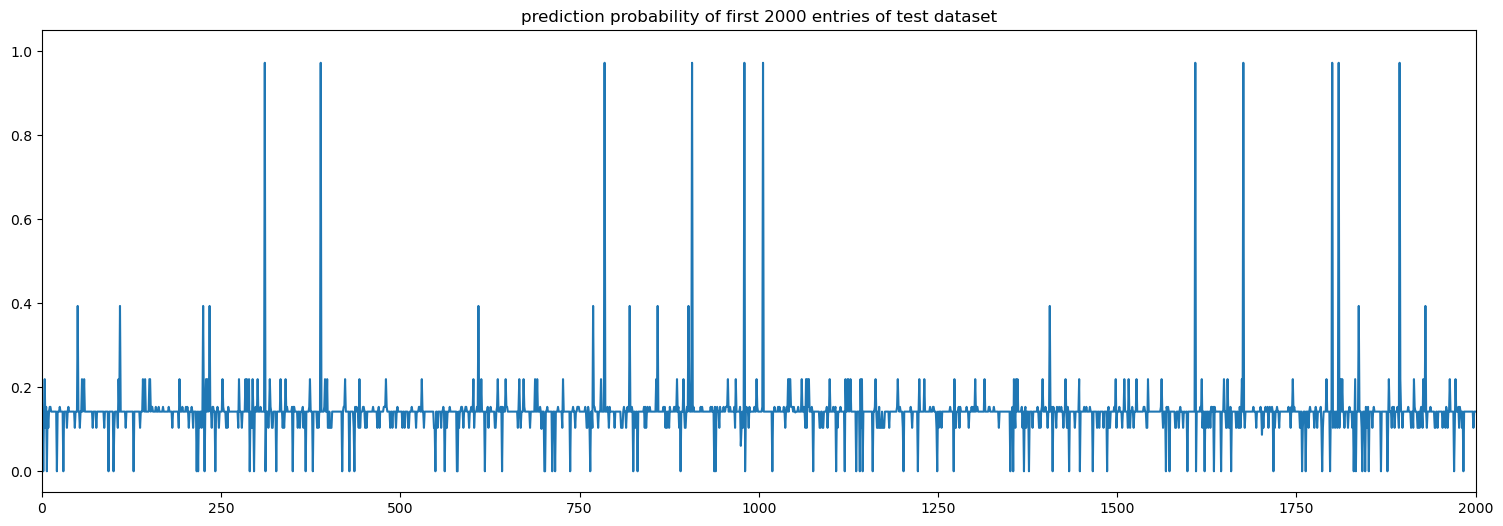

In [151]:
clf = train_classifier('decision_tree', X_train, y_train)
test_accuracy(clf, X_test, y_test, X_train, y_train)
plot_test_results(clf, X_test, y_test)

In [148]:
# saved directly to working directory
plot_decision_tree(clf, df, filename)

#### Comparison Logistic Regression vs. Decision Tree

In [149]:
clf_logreg = LogisticRegression()
clf_logreg.fit(X_train, y_train)
clf_dectree = DecisionTreeClassifier()
clf_dectree.fit(X_train, y_train)

DecisionTreeClassifier()

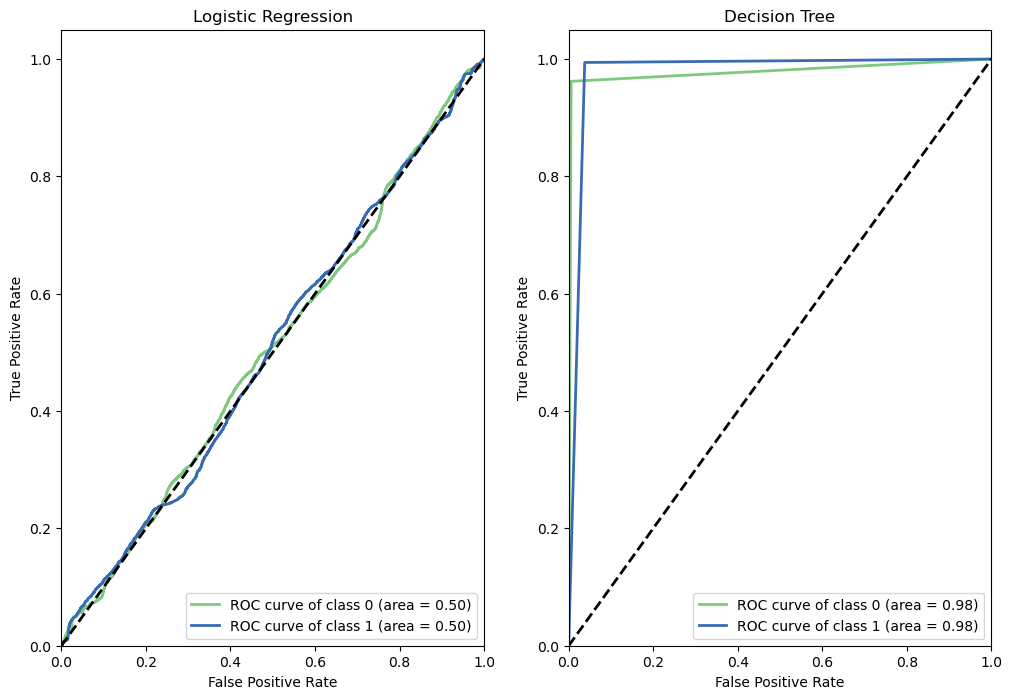

In [165]:
predicted_probas_logreg = clf_logreg.predict_proba(X_test)
predicted_probas_dectree = clf_dectree.predict_proba(X_test)
# y_test = ground truth, predicted_probas = 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.set_title('LogisticRegression')
ax2.set_title('DecisionTreeClassifier')
skplt.metrics.plot_roc(y_test, predicted_probas_logreg,ax=ax1, plot_micro=False, plot_macro=False, title = 'Logistic Regression', cmap='Accent',)
skplt.metrics.plot_roc(y_test, predicted_probas_dectree,ax=ax2, plot_micro=False, plot_macro=False, title = 'Decision Tree', cmap='Accent',)
plt.show()